## Семинар 3 "Определение ключевых точек лица"

## Задание

Используя датасет из архива решите задачу регрессии для поиска 68-ми ключевых точек лица. 

Для обучения и валидации используйте изображения и разметку из папок train и test соответственно.

Для **зачета** дз нужно сделать одно из двух:

1. Исследовать 6 разных архитектур и написать подробный вывод + мысли почему одна сеть работает лучше чем другая (разные функции активации, глубины сетей, размеры и типы слоев)
2. Преодолеть порог MSE=8 на тесте


Также до  22 марта 23:59 можно получить до 5 дополнительных баллов за лучшее решение. (За первое место 5 баллов, за второе — 3 балла, за третье — 1 балла.)

Для решения можно пользоваться всем инструментарием, с которым мы познакомимся:  предобученные модели, сверточные сети, любые оптимизаторы, batchnorm, dropout, etc.

In [1]:
%matplotlib inline
import os
import torch
import sys
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.nn import MSELoss, Sequential, Linear, Sigmoid, Tanh, L1Loss, Module, Parameter
from torch.autograd import Variable
# Ignore warnings
import warnings


try:
    from tensorboardX import SummaryWriter
except ImportError:
    raise RuntimeError("No tensorboardX package is found. Please install with the command: \npip install tensorboardX")

from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss




Image name: 109.jpeg
Landmarks shape: (68, 2)
First 4 Landmarks: [[ 7. 41.]
 [ 8. 51.]
 [10. 60.]
 [13. 70.]]


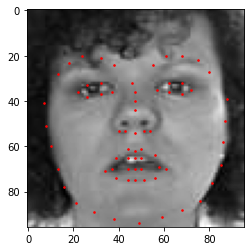

In [2]:
warnings.filterwarnings("ignore")

landmarks_frame = pd.read_csv('dataset/train/face_landmarks.csv')

n = 100
img_name = landmarks_frame.iloc[n, 0]
landmarks = landmarks_frame.iloc[n, 1:].to_numpy().astype('float')
landmarks = landmarks.reshape(-1, 2)

print('Image name: {}'.format(img_name))
print('Landmarks shape: {}'.format(landmarks.shape))
print('First 4 Landmarks: {}'.format(landmarks[:4]))

def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    plt.imshow(image, cmap='gray')
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='red', cmap='rgb')
    plt.pause(0.001)  

plt.figure()
show_landmarks(io.imread(os.path.join('dataset/train/', img_name)),
               landmarks)
plt.show()

In [3]:
def show_landmarks_batch(sample_batch, y_pred=None):
    """Show image with landmarks for a batch of samples."""
    images_batch, landmarks_batch = \
            sample_batch
    batch_size = len(images_batch)
    im_size = images_batch.size(2)

    grid = utils.make_grid(images_batch)
    print(images_batch.numpy().shape)
    plt.imshow(grid.numpy().transpose(1,0,2).reshape(im_size, -1), cmap="gray")

    for i in range(batch_size):
        plt.scatter(landmarks_batch[i, :, 0].numpy() + i * im_size,
                    landmarks_batch[i, :, 1].numpy(),
                    s=10, marker='.', c='r', label='Real')

    if type(y_pred) != type(None):
        for i in range(batch_size):
            plt.scatter(y_pred[i, :, 0] + i * im_size,
                        y_pred[i, :, 1],
                        s=10, marker='.', c='b',  label='Prediction')
        plt.title('Batch from dataloader')
    plt.legend()

In [4]:
class FaceLandmarksDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.landmarks_frame.iloc[idx, 0])
        image = io.imread(img_name)
        landmarks = self.landmarks_frame.iloc[idx, 1:].to_numpy().astype('float')
        landmarks = landmarks.reshape(-1, 2)
        sample = image, landmarks

        if self.transform:
            sample = self.transform(sample)

        return sample

In [2]:
class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        landmarks = landmarks - [left, top]

        return image, landmarks




class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, landmarks = sample
        return torch.from_numpy(image).type(torch.float), torch.from_numpy(landmarks).type(torch.float)

In [6]:
train_dataset = FaceLandmarksDataset(csv_file='dataset/train/face_landmarks.csv',
                                     root_dir='dataset/train',
                                     transform=ToTensor())

test_dataset = FaceLandmarksDataset(csv_file='dataset/test/face_landmarks.csv',
                                     root_dir='dataset/test',
                                     transform=ToTensor())

In [7]:
def get_data_loaders(train_batch_size=64, val_batch_size=64):

    train_loader = DataLoader(
        train_dataset, batch_size=train_batch_size, shuffle=True
    )

    test_loader = DataLoader(
        test_dataset, batch_size=val_batch_size, shuffle=False
    )

    return train_loader, test_loader

In [8]:
class Net(Module):
    def __init__(self, activation=Sigmoid(), latent_size=200):
        super().__init__()
        self.fc1 =Linear(96 * 96, 200)
        self.fc2 = Linear(200, 68 * 2)
        self.activation = activation
    def forward(self, x):
        return self.fc2(self.activation(self.fc1(x.view(x.shape[0], -1)))).view(x.shape[0], 68, 2)

In [99]:
network = Net()
train_dataloader, test_dataloader = get_data_loaders()
writer = SummaryWriter(filename_suffix='first', logdir="logs")

device = "cpu"

if torch.cuda.is_available():
    device = "cuda"
criterion = MSELoss()
optim = torch.optim.Adam
learning_rate = 0.01
max_epochs = 10

optimizer = optim(network.parameters(), lr=learning_rate)
print(device)
trainer = create_supervised_trainer(network, optimizer, criterion, device="cpu")
evaluator = create_supervised_evaluator(
    network, metrics={"L2 loss": Loss(criterion), "L1 loss": Loss(L1Loss())}, device="cpu"
)

training_history = {'l1':[],'l2':[]}
validation_history = {'l1':[],'l2':[]}
last_epoch = []
device

cuda


'cuda'

In [100]:
@trainer.on(Events.ITERATION_COMPLETED(every=10))
def log_training_loss(engine):
    writer.add_scalar("training/loss", engine.state.output, engine.state.iteration)
    writer.flush()


@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    evaluator.run(train_dataloader)
    metrics = evaluator.state.metrics
    l2_train = metrics["L2 loss"]
    l1_train = metrics['L1 loss']
    last_epoch.append(0)
    training_history['l2'].append(l2_train)
    training_history['l1'].append(l1_train)
    writer.add_scalar("training/epoch_loss", l2_train, trainer.state.epoch)
    
    evaluator.run(test_dataloader)
    metrics = evaluator.state.metrics
    l2 = metrics["L2 loss"]
    l1 = metrics['L1 loss']
    validation_history['l2'].append(l2)
    validation_history['l1'].append(l1)
    
    writer.add_scalar("validation/epoch_loss", l2, trainer.state.epoch)
    writer.flush()
    
    sys.stdout.write("\rTraining/Validation Results - Epoch: {}  Avg MSE: {:.2f} / {:.2f} Avg MAE: {:.2f} / {:.2f}"
          .format(trainer.state.epoch, l2_train, l2, l1_train, l1))
   

In [ ]:
trainer.run(train_dataloader, max_epochs=max_epochs)

In [ ]:
writer.close()

In [ ]:
train(network, 4, 1e-1)

(2, 96, 96)


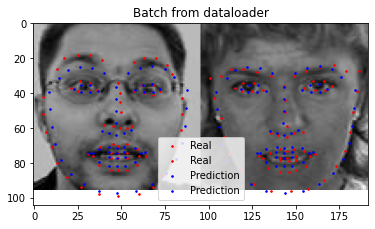

In [ ]:
_, test_dataloader = get_data_loaders(val_batch_size=2)

images_batch = next(iter(test_dataloader))
x, y = images_batch
y_pred = network(x)
y_pred = y_pred.data.numpy()
show_landmarks_batch(images_batch, y_pred)

-------------------
# Homework Part
## ФИО: Вартанов Дмитрий Александрович

Для обучения будем использовать 40 эпох и три сети:
1) Более сложная версия **Net** из занятия
2) Сверточная сеть с **MaxPool2d**
3) Сверточная сеть без **MaxPool2d** (если мой компуктер вывезет конечно :))

Добавил свою функцию обучения для удобства, в которой лосс считается абсолютно также, как и на занятии (в чем можно убедиться на сети **Net()** или посмотрев код), а также переработал все под возможность использования **cuda** (хоть мой ноутбук с ней и не в ладах).

In [19]:
from torch import nn
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.nn import MSELoss, Sequential, Linear, Sigmoid, Tanh, L1Loss, Module, Parameter
from torch.autograd import Variable
import sys
import os
import pandas as pd
from skimage import io
import matplotlib.pyplot as plt
device = "cpu"
#if torch.cuda.is_available():
#    device = "cuda"
device

'cpu'

In [20]:
class FaceLandmarksDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.landmarks_frame.iloc[idx, 0])
        image = io.imread(img_name)
        landmarks = self.landmarks_frame.iloc[idx, 1:].to_numpy().astype('float')
        landmarks = landmarks.reshape(-1, 2)
        sample = image, landmarks

        if self.transform:
            sample = self.transform(sample)

        return sample

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, landmarks = sample
        return torch.from_numpy(image).type(torch.float).to(device), torch.from_numpy(landmarks).type(torch.float).to(device)

In [21]:
train_dataset = FaceLandmarksDataset(csv_file='dataset/train/face_landmarks.csv',
                                     root_dir='dataset/train',
                                     transform=ToTensor())

test_dataset = FaceLandmarksDataset(csv_file='dataset/test/face_landmarks.csv',
                                     root_dir='dataset/test',
                                     transform=ToTensor())

def get_device_data_loaders(train_batch_size=64, val_batch_size=64, device="cpu"):

    train_loader = DataLoader(
        train_dataset, batch_size=train_batch_size, shuffle=True
    )

    test_loader = DataLoader(
        test_dataset, batch_size=val_batch_size, shuffle=False
    )

    return train_loader, test_loader

In [22]:
def my_train(clf, epochs, optimizer, criterion, train_data, test_data):

    #Задаем минимальный лосс для сохранения лучшей модели в процессе обучения
    cur_min_loss = 10e8
    train_losses = []
    test_losses = []

    #Обучение
    for epoch_step in range(epochs):
        
        #Трейн лосс для текущей эпохи
        epoch_loss = 0.0

        for i, batch in enumerate(train_data):

            X, y = batch

            optimizer.zero_grad()
            prediction = clf(X.to(device))

            loss = criterion(prediction, y.to(device))
            epoch_loss += loss.item()

            loss.backward()
            optimizer.step()

        #Считаем лосс на тестовой выборке  
        epoch_test_loss = criterion(clf(test_data[0]), test_data[1]).item()

        train_losses.append(epoch_loss / (i + 1)), test_losses.append(epoch_test_loss)

        #Если на текущей эпохе лосс на тесте минимален, то сейвим модель
        if epoch_test_loss < cur_min_loss:
            cur_min_loss = epoch_test_loss
            checkpoint = {'model': clf,
                          'state_dict': clf.state_dict(),
                          'optimizer' : optimizer.state_dict()}
            torch.save(checkpoint, f'{clf.name()}.pth')

        sys.stdout.flush()
        sys.stdout.write(f"\rEpoch: {epoch_step + 1}, epoch steps: {i + 1}. Epoch MSE_train: {np.round(epoch_loss / (i + 1), decimals=2)}; Epoch MSE_test: {np.round(epoch_test_loss, decimals=2)}")
        
    #Берем со третьей эпохи, так как первые две имеют сравнительно огромные лоссы и портят графики
    train_losses, test_losses = np.array(train_losses)[1:], np.array(test_losses)[1:]
    plt.plot(np.arange(2, epochs + 1), train_losses)
    plt.plot(np.arange(2, epochs + 1), test_losses)
    plt.title("Train/Test Loss")
    plt.grid()
    plt.legend(['Train loss', 'Test loss'])
    min_loss, min_epoch = test_losses.min(), test_losses.argmin()
    plt.scatter(min_epoch, min_loss, c="red")
    plt.text(min_epoch, min_loss - (plt.ylim()[1] - plt.ylim()[0]) * 0.05, f"({min_epoch, np.round(min_loss, decimals=3)})", ha="center")
    

In [23]:
train_dataloader, test_dataloader = get_device_data_loaders(device=device)
X_test, y_test = torch.Tensor([]).to(device), torch.Tensor([]).to(device)
for batch in test_dataloader:
    X_test = torch.cat((X_test, batch[0]))
    y_test = torch.cat((y_test, batch[1]))
X_test = X_test.to(device)
y_test = y_test.to(device)

In [24]:
criterion = MSELoss()
optimizer = torch.optim.Adam
max_epochs = 40

### Линейная моделька

In [302]:
class MyNet1(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(96 * 96, 200),
            nn.Sigmoid(),
            nn.Linear(200, 100),
            nn.ReLU(),
            nn.Linear(100, 68 * 2)
        )
    def forward(self, X):
        return self.net(X).reshape(X.shape[0], 68, 2)
    
    def name(self):
        return 'Simple_Linear'


Epoch: 40, epoch steps: 98. Epoch MSE_train: 17.64; Epoch MSE_test: 18.82

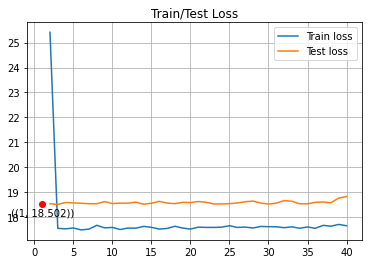

In [303]:
n1 = MyNet1().to(device)
my_train(n1, max_epochs, optimizer(n1.parameters(), 0.001), nn.MSELoss(), train_dataloader, (X_test, y_test))

Улучшений по сравнению с **Net()** из занятия не получено. Минимальный лосс для данной модели составил ***18.502***

### Сверточные сети
Для изображений все-таки подходят лучше сверточные сети, поэтому попробуем их:

In [25]:
class MyNet2(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 4, 3, padding="same"),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(4),
            nn.Conv2d(4, 8, 3, padding="same"),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Conv2d(8, 16, 3, padding="same"),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Dropout(0.2),
            nn.Linear(96 * 96, 200),
            nn.LeakyReLU(0.05),
            nn.Linear(200, 68 * 2)
        )
    def forward(self, X):
        return self.net(X.reshape(X.shape[0], 1, X.shape[1], X.shape[2])).reshape(X.shape[0], 68, 2)
    
    def name(self):
        return 'Conv1'

Epoch: 40, epoch steps: 98. Epoch MSE_train: 2.62; Epoch MSE_test: 4.97

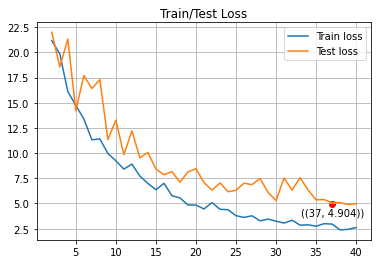

In [26]:
n2 = MyNet2().to(device)
my_train(n2, max_epochs, optimizer(n2.parameters(), 0.01), nn.MSELoss(), train_dataloader, (X_test, y_test))

Ожидаемо сверточная сеть сильно превосходит обычную линейку, поэтому проведем еще один эксперимент с другой сверточной сетью. 

Отмечу, что можно было бы обучать сеть и на большем количестве эпох с чекпоинтами, но мне жалко мой ноутбук, а с **colab** запариваться по поводу загрузки данных пока немного лень) Впрочем, и без того, baseline довольно уверенно пройден. Также из графика видно, что переобучение еще точно не началось, так как лучшей на валидации оказалась одна из последних эпох + в конце нет диких скачков вверх по валидации.

Лучший результат для данной модельки, исходя из результатов, составил **4.904** на эпохе. Модель на данном этапе мы как раз и сохранили. 

In [30]:
class MyNet3(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 5, 3, padding="same"),
            nn.ReLU(),
            nn.BatchNorm2d(5),
            #nn.MaxPool2d(2),
            nn.Conv2d(5, 10, 3, padding="same"),
            nn.ReLU(),
            nn.BatchNorm2d(10),
            #nn.MaxPool2d(2),
            nn.Conv2d(10, 20, 3, padding="same"),
            nn.ReLU(),
            nn.BatchNorm2d(20),
            nn.Conv2d(20, 30, 3, padding="same"),
            nn.ReLU(),
            nn.BatchNorm2d(30),
            nn.Flatten(),
            nn.Linear(96 * 96 * 30, 200),
            nn.Dropout(0.2),
            nn.LeakyReLU(0.05),
            nn.Linear(200, 68 * 2)
        )
    def forward(self, X):
        return self.net(X.reshape(X.shape[0], 1, X.shape[1], X.shape[2])).reshape(X.shape[0], 68, 2)
    
    def name(self):
        return 'Conv2'

In [ ]:
n3 = MyNet3().to(device)
my_train(n3, max_epochs, optimizer(n3.parameters(), 0.01), nn.MSELoss(), train_dataloader, (X_test, y_test))

**MyNet3** нормально не прогнать на ноуте, поэтому жду доступ к серверам или на колабе прогоню уже после дедлайна. Baseline и без нее побит в принципе


## Пример работы

In [32]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = checkpoint['model']
    model.load_state_dict(checkpoint['state_dict'])
    for parameter in model.parameters():
        parameter.requires_grad = False
    model.eval()
    return model

model = load_checkpoint('Conv1.pth')

In [63]:
X = X_test[3:].numpy()
y = y_test[3:]
y_pred = model(X_test[3:])
print(f"MSE ON 3 following images: {MSELoss()(y,  y_pred).item()}")
y = y.numpy()
y_pred = y_pred.numpy()

MSE ON 3 following images: 4.392205715179443


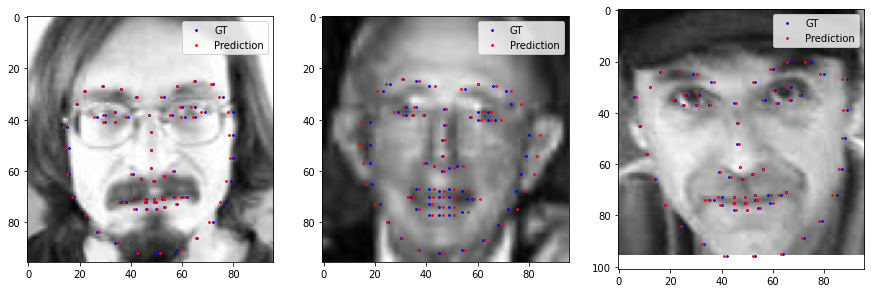

In [64]:
fig, ax = plt.subplots(ncols=3)
fig.set_figheight(5)
fig.set_figwidth(15)
for i in range(3):
    ax[i].imshow(X[i], cmap='gray')
    ax[i].scatter(y[i][:, 0], y[i][:, 1], s=3, c='b')
    ax[i].scatter(y_pred[i][:, 0], y[i][:, 1], s=3, c='r')
    ax[i].legend(['GT', 'Prediction'])

## Выводы

С моделью **MyNet2** удалось добиться **MSELoss = 4.904**  на тестовой выборке. Все ещё можно улучшить этот результат за счет большего числа эпох и/или более тяжелой модели

Свертки работают лучше, потому что мы имеем дело изображениями, у которых сильно важна локальная область пикселя. Это и дает такое сильно преимущество на мой взгляд